In [389]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [390]:
env = gym.make('CartPole-v1')

n_actions = env.action_space.n
n_states = env.observation_space.shape[0]
print("Action space size: ", n_actions)
print("State space size: ", n_states)

print('\nStates high values:')
print(env.observation_space.high[0])
print(env.observation_space.high[1])
print(env.observation_space.high[2])
print(env.observation_space.high[3])

print('\nStates low values:')
print(env.observation_space.low[0])
print(env.observation_space.low[1])
print(env.observation_space.low[2])
print(env.observation_space.low[3])


buckets = (1, 1, 6, 12)

upper_bounds = [
        env.observation_space.high[0],
        0.5,
        env.observation_space.high[2],
        math.radians(50)
        ]
lower_bounds = [
        env.observation_space.low[0],
        -0.5,
        env.observation_space.low[2],
        -math.radians(50)
        ]

n_episodes = 2000
n_steps = 200
min_alpha = 0.05
min_epsilon = 0.05
gamma = 0.99
decay_rate = 25

Action space size:  2
State space size:  4

States high values:
4.8
3.4028235e+38
0.41887903
3.4028235e+38

States low values:
-4.8
-3.4028235e+38
-0.41887903
-3.4028235e+38


In [391]:
Q = np.zeros(buckets + (n_actions,))
print(np.shape(Q))

(1, 1, 6, 12, 2)


In [392]:
def discretize(obs):
    ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
    new_obs = [int(round((buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
    new_obs = [min(buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
    return tuple(new_obs)

In [393]:
def epsilon_greedy_strategy(state, eps):
    random_exploration_exploitation = np.random.random()
    if random_exploration_exploitation <= eps:
        new_action = env.action_space.sample()
    else:
        new_action = np.argmax(Q[state])
    return new_action

In [394]:
def greedy_strategy(state):
    return np.argmax(Q[state])

In [395]:
def update_q_table(current_state, action, reward, new_state, alpha):
    Q[current_state][action] += alpha * (reward + gamma * np.max(Q[new_state]) - Q[current_state][action])

In [396]:
def plot_results(n_ep, rewards):
    x = range(n_ep)
    plt.plot(x, rewards)
    plt.xlabel('Episode number')
    plt.ylabel('Reward')
    plt.show()

# Train

In [397]:
rewards_for_episodes = []
for episode in range(n_episodes):
    current_state = env.reset()
    current_state = discretize(current_state)
    
    #alpha = 0.2
    #epsilon = 0.4
    alpha = max(min_alpha, min(1.0, 1.0 - math.log10((episode + 1) / decay_rate)))
    epsilon = max(min_epsilon, min(1.0, 1.0 - math.log10((episode + 1) / decay_rate)))

    episode_reward_acc = 0

    for t in range(n_steps):
        #env.render()
        action = epsilon_greedy_strategy(current_state, epsilon)
        new_state, reward, done, _ = env.step(action)
        new_state = discretize(new_state)
        update_q_table(current_state, action, reward, new_state, alpha)
        current_state = new_state

        episode_reward_acc += reward

        if done:
            print('Episode:{}/{} failed with a total reward of: {}'.format(episode, n_episodes, episode_reward_acc))
            break
    #if episode_reward_acc == 200:
        #alpha = 0.1
        #epsilon = 0.1
        #break
    rewards_for_episodes.append(episode_reward_acc)

Episode:0/2000 failed with a total reward of: 16.0
Episode:1/2000 failed with a total reward of: 11.0
Episode:2/2000 failed with a total reward of: 15.0
Episode:3/2000 failed with a total reward of: 11.0
Episode:4/2000 failed with a total reward of: 16.0
Episode:5/2000 failed with a total reward of: 26.0
Episode:6/2000 failed with a total reward of: 11.0
Episode:7/2000 failed with a total reward of: 20.0
Episode:8/2000 failed with a total reward of: 14.0
Episode:9/2000 failed with a total reward of: 16.0
Episode:10/2000 failed with a total reward of: 14.0
Episode:11/2000 failed with a total reward of: 14.0
Episode:12/2000 failed with a total reward of: 19.0
Episode:13/2000 failed with a total reward of: 51.0
Episode:14/2000 failed with a total reward of: 34.0
Episode:15/2000 failed with a total reward of: 23.0
Episode:16/2000 failed with a total reward of: 27.0
Episode:17/2000 failed with a total reward of: 14.0
Episode:18/2000 failed with a total reward of: 21.0
Episode:19/2000 failed

In [398]:
np.save('Q_table.npy', Q)

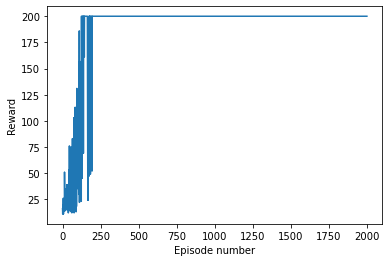

In [399]:
plot_results(len(rewards_for_episodes), rewards_for_episodes)

# Test

In [400]:
Q = np.load('Q_table.npy')

current_state = env.reset()
current_state = discretize(current_state)
episode_reward = 0
test_steps = 200

for t in range(test_steps):
    env.render()
    action = greedy_strategy(current_state)
    new_state, reward, done, _ = env.step(action)
    new_state = discretize(new_state)
    update_q_table(current_state, action, reward, new_state, min_alpha)
    current_state = new_state
    episode_reward += reward
    time.sleep(0.02)

    if done:
        print('Test episode failed with a total reward of: {}'.format(episode_reward))
        break

print('Test episode(with {} steps) finished with a total reward of: {}'.format(test_steps, episode_reward))

env.close()

Test episode(with 200 steps) finished with a total reward of: 200.0
